In [2]:
# from fastai.imports import *
import numpy as np
import pandas as pd


np.set_printoptions(linewidth=110)

### Titanic problem

We have a tabular dataset containing info about Titanic's passengers. The goal of the model is to predict if a person survided or not to the well-known accident.

### Data preprocessing

In [3]:
import os

datasets_base_path = "../../../../datasets"
trainset_path = os.path.join(datasets_base_path, "titanic_train.csv")
testset_path = os.path.join(datasets_base_path, "titanic_test.csv")

df = pd.read_csv(trainset_path)
df_test = pd.read_csv(testset_path)

df.shape, df_test.shape

((891, 12), (418, 11))

One difference with Random Forests however is that we don't generally have to create _dummy variables_ like we did for non-numeric columns in the linear models and neural network. 

Instead, we can just convert those fields to categorical variables, which internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number.

In [4]:
def process_data(df, modes):
    df["Fare"] = df.Fare.fillna(0) # fill NaN values in Fare with 0
    df.fillna(modes, inplace=True) # fill NaN values in another columns with modes
    df["LogFare"] = np.log1p(df["Fare"]) # calculate a new column called LogFare, log(Fare + 1)
    df["Embarked"] = pd.Categorical(df.Embarked) # get categories for the set of values of Embarqued
    df["Sex"] = pd.Categorical(df.Sex) # similar idea to the Embarqued columnd

In [5]:
modes = df.mode().iloc[0]
process_data(df, modes)
process_data(df_test, modes)

In [6]:
"""Note that we no longer consider Pclass a categorical variable. 
That's because it's ordered (i.e 1st, 2nd, and 3rd class have an order), 
and decision trees, as we'll see, only care about order, not about absolute value.
"""
cats = ["Sex","Embarked"] # categorical
conts = ['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"] # continuous
dep = "Survived" # dependent one: Y


Even although we've made the cats columns categorical, they are still shown by Pandas as their original values:

In [7]:
df.Sex.head()


0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

However behind the scenes they're now stored as integers, with indices that are looked up in the Categories list shown in the output above

In [8]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

### Binary splits

To create a decision tree, we will first need to create a binary split, since that's what a decision tree is built from.

A binary split categorizes rows into two groups according to a specific threshold in a chosen column. For instance, in a dataset with a 'Sex' column, where '0' represents female and '1' represents male, applying a 0.5 threshold effectively divides the dataset into male and female groups.

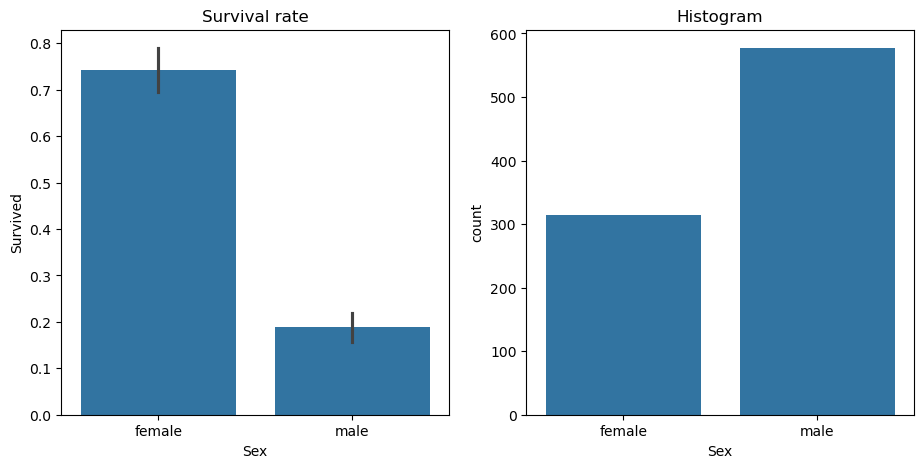

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1, 2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Survival rate displays the percentage of person (by sex) who has a survived target of 1. While the histogram displays the amount of persons (by sex).


We could create a very simple "model" which simply says that all females survive, and no males do. We first split our data into a training and validation set, to see how accurate this approach turns out to be:

In [10]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

trn_df, val_df = train_test_split(df, test_size=0.25) # 75% of data for training
# Replace categorical columns by their code values assigned by Pandas
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [11]:
# We can create our independent variables (the x variables) and the dependent (y variables)

def xs_y(df):
    """Return a tuple(x, y), y might be None if dep is not present in the given df."""
    xs = df[cats+conts].copy()
    return (xs, df[dep] if dep in df else None)


trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [12]:
trn_xs

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
298,1,2,24.00,0,0,3.449988,1
884,1,2,25.00,0,0,2.085672,3
247,0,2,24.00,0,2,2.740840,2
478,1,2,22.00,0,0,2.142510,3
305,1,2,0.92,1,2,5.027492,1
...,...,...,...,...,...,...,...
106,0,2,21.00,0,0,2.157559,3
270,1,2,24.00,0,0,3.465736,1
860,1,2,41.00,2,0,2.715244,3
435,0,2,14.00,1,2,4.795791,1


In [13]:
trn_y

298    1
884    0
247    1
478    0
305    1
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 668, dtype: int64

In [14]:
# Here our VERY simple model

FEMALE_CODE = 0

preds = val_xs.Sex == FEMALE_CODE

preds[:5]

709    False
439    False
840    False
720     True
39      True
Name: Sex, dtype: bool

In [15]:
from sklearn.metrics import mean_absolute_error

# calculate MAE
mean_absolute_error(val_y, preds)

0.21524663677130046

Alternatively, we could try splitting on a continuous column.

<AxesSubplot:xlabel='LogFare', ylabel='Density'>

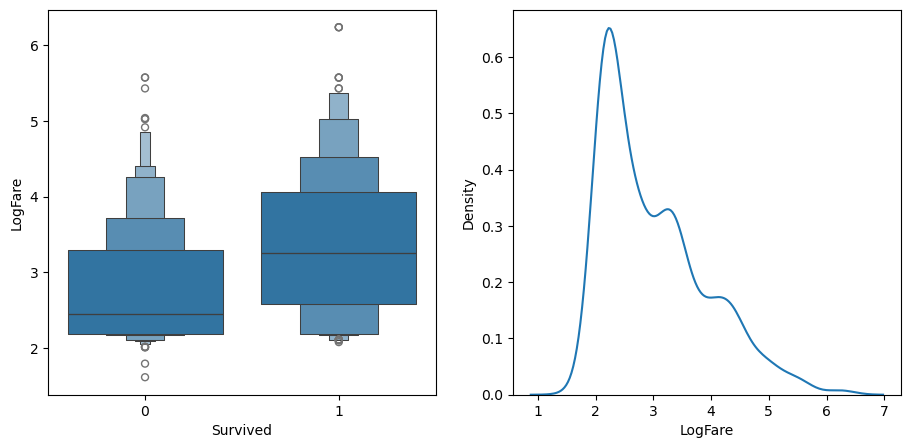

In [16]:
df_fare = trn_df[trn_df.LogFare > 0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
# Like a traditional box plot, the boxen plot shows the median, quartiles, and potential outliers in the data.
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
# KDE (Kernel Density Estimate) plots are used for visualizing the probability density of a 
# continuous variable or variables. It's a way to estimate the probability density function 
# of a continuous random variable.
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1])

The boxenplot above shows quantiles of `LogFare` for each group of `Survived==0` and `Survived==1`. It shows that the average `LogFare` for passengers that didn't survive is around 2.5, and for those that did it's around 3.2. Let's create a simple model based on this observation:

In [17]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y, preds) # it's worse comparing to sex split

0.336322869955157

We'd like some way to try more columns and breakpoints more easily. We could create a function that returns how good our model is, in order to more quickly try out a few different splits.

We'll create a score function to do this. Instead of returning the mean absolute error, we'll calculate a measure of impurity -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

In [31]:
def _side_score(side: pd.Series, y: pd.Series):
    """We can measure the similarity of rows inside a group by taking the standard deviation of 
    the dependent variable. If it's higher, then it means the rows are more different to 
    each other. We'll then multiply this by the number of rows, since a bigger group as more 
    impact than a smaller group.
    """
    tot = side.sum()

    if tot <= 1:
        return 0

    return y[side].std() * tot

In [32]:
def score(col: pd.Series, y: pd.Series, split_threshold: float):
    """we can calculate the score for a split by adding up the scores for the "left hand side" 
    (lhs) and "right hand side" (rhs)."""

    lhs = col <= split_threshold

    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

In [33]:
score(trn_xs["Sex"], trn_y, 0.5)


0.40787530982063946

In [34]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

To make it easier to find the best binary split, we can create a simple interactive tool

In [35]:
from ipywidgets import interact


def iscore(column_name, split_threshold):
    col = trn_xs[column_name]

    return score(col, trn_y, split_threshold)


interact(column_name=conts, split_threshold=15.5)(iscore)

interactive(children=(Dropdown(description='column_name', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass…

<function __main__.iscore(column_name, split_threshold)>

What splits can you find that increase the purity of the data?
- Age: 5.8 (0.4788)
- SibSp: 4.0 (0.4783)
- Parch: 0.7 (0.4805)
- LogFare: 2.4 (0.4631)
- Pclass: 2.4 (0.4604)

We can do the same thing for the categorical variables:



In [36]:
interact(column_name=cats, split_threshold=2)(iscore)

interactive(children=(Dropdown(description='column_name', options=('Sex', 'Embarked'), value='Sex'), IntSlider…

<function __main__.iscore(column_name, split_threshold)>

That works well enough, but it's rather slow and fiddly. Perhaps we could get the computer to automatically find the best split point for a column for us?

In [37]:
"""For example, to find the best split point for age we'd first need to make a list of all
the possible split points (i.e all the unique values of that field).
"""
column_name: str = "Age"
col = trn_xs[column_name: str]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  , 11.  , 12.  , 13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  ,
       23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  ,
       45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 56.  ,
       57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [39]:
# ...and find which index of those values is where score() is the lowest

scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])

min_idx = scores.argmin()
unq[min_idx] # age 6 is the best threshold

6.0

We can write a little function that implements the previous idea

In [42]:
def min_col(df, column_name: str) -> tuple:
    """Returns the threshold value and the associated score which is minimum considerding 
    all possible vslues for the given column name."""

    col, y = df[column_name], df[dep]

    unq = col.dropna().unique()

    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()

    return unq[idx], scores[idx]

In [43]:
# Compute for all columns
all_cols = cats + conts

{column: min_col(trn_df, column) for column in all_cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

**According to this, Sex<=0 is the best split we can use.**

We've just re-invented the OneR classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993. Since it's so simple and surprisingly effective, it a great baseline.

### Creating a decision tree

How can we improve our OneR classifier, which predicts survival based only on the column Sex?


How about we take each of our two groups, female and male, and create one more binary split for each of them.

That is: fine the single best split for females, and the single best split for males. To do this, all we have to do is repeat the previous section's steps, once for males, and once for females.

In [44]:
"""First, we'll remove Sex from the list of possible splits (since we've already used it, 
and there's only one possible split for that binary column), and create our two groups"""

all_cols.remove("Sex")
ismale = trn_df.Sex == 1

males, females = trn_df[ismale], trn_df[~ismale]

In [46]:
# Now let's find the single best binary split for males...:
{column: min_col(males, column) for column in all_cols} # it's age with threshold of 6

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [47]:
# and for females
{column :min_col(females, column) for column in all_cols} # it's pClass with threshold 2

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

By adding these rules, we have created a decision tree, where our model will first check whether Sex is female or male, and depending on the result will then check either the above Age or Pclass rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.

But this time we will use an existing library to avoid repeat code many times.

In [48]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [49]:
# We can draw the decision tree, it's so cool this
import re

import graphviz


def draw_tree(tree_model, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(
        tree_model,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=False,
        precision=precision,
        **kwargs,
    )

    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

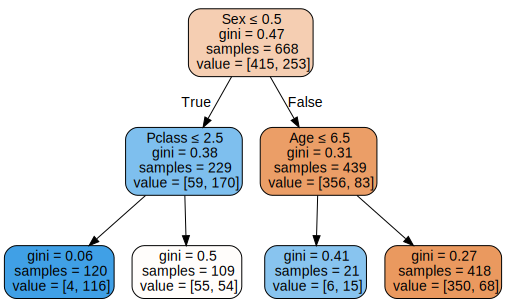

In [50]:
draw_tree(model, trn_xs, size=10)

In the picture, the more orange nodes have a lower survival rate, and blue have higher survival.
Values display how many people die or survive, `Value = [die, survive]`.

There's also something called "gini". That's another measure of impurity.

In [57]:
def gini(condition: pd.Series):
    """What this calculates is the probability that, if you pick two rows from a group, 
    you'll get the same Survived result each time. If the group is all the same, 
    the probability is 1.0, and 0.0 if they're all different.
    """

    # Conditional that returns a boolean Series with column labels specified
    act = df.loc[condition, dep]

    return 1 - act.mean()**2 - (1-act).mean()**2

In [56]:
condition = df.Sex == "female"

df.loc[condition, dep]

1      1
2      1
3      1
8      1
9      1
      ..
880    1
882    0
885    0
887    1
888    0
Name: Survived, Length: 314, dtype: int64

In [58]:
gini(df.Sex == "female"), gini(df.Sex == "male")

(0.3828350034484158, 0.3064437162277842)

In [59]:
# Let's see how this model compares to our OneR version

mean_absolute_error(val_y, model.predict(val_xs))

0.2242152466367713

It's a tiny bit worse. Since this is such a small dataset (we've only got around 200 rows in our validation set) this small difference isn't really meaningful. Perhaps we'll see better results if we create a bigger tree:

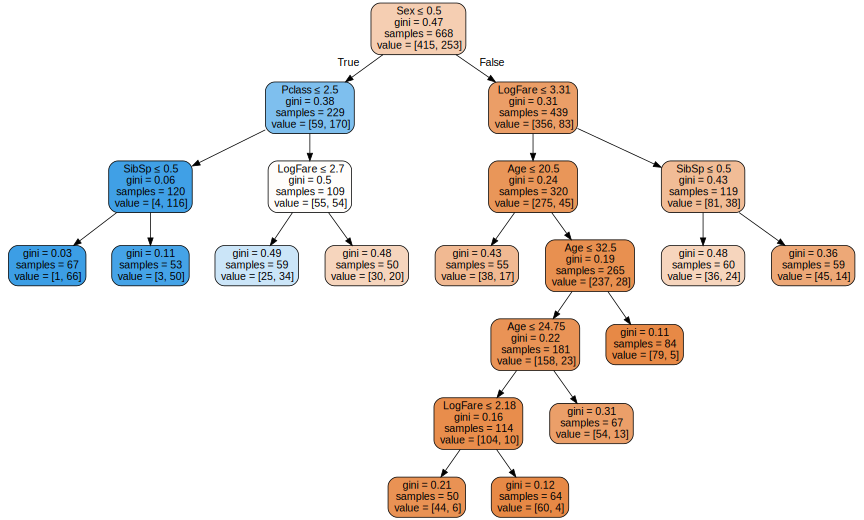

In [60]:
bigger_model = DecisionTreeClassifier(min_samples_leaf=50) # we need that each leaf has at least 50 samples
bigger_model.fit(trn_xs, trn_y)
draw_tree(bigger_model, trn_xs, size=12)

In [61]:
mean_absolute_error(val_y, bigger_model.predict(val_xs)) # best resuls so far

0.18385650224215247

### The random forest


We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them.

what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as bagging.

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value..

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data

In [73]:
import random


def get_tree(prop: float = 0.75):
    n = len(trn_y)
    # get prop % of indices randomly selected from the range of indexes
    idxs = random.choices(range(n), k=int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [74]:
trees = [get_tree(0.55) for t in range(100)]

In [75]:
# Our prediction will be the average of these trees' predictions:

all_probs = [tree.predict(val_xs) for tree in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.22434977578475337

This is nearly identical to what sklearn's RandomForestClassifier does.

The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split.

In [76]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.19282511210762332

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using `feature_importances_`

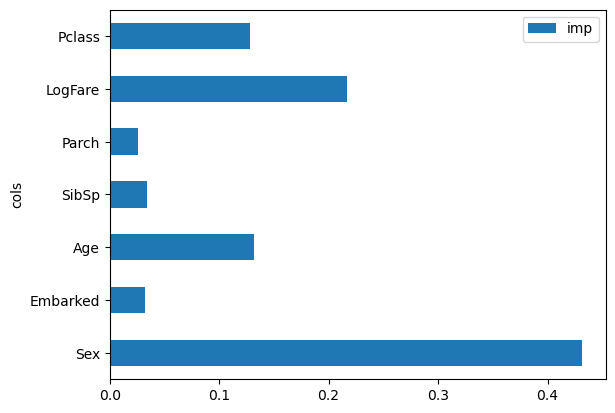

In [77]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot("cols", "imp", "barh");

We can see that `Sex` is by far the most important predictor, with `Pclass` a distant second, and `LogFare` and `Age` behind that.

- More complex models aren't always better...

- So we should always be careful to benchmark simple models, as see if they're good enough for our needs.

- Random forests aren't actually that complicated at all. And they aren't sensitive to issues like normalization, interactions, or non-linear transformations, which make them extremely easy to work with, and hard to mess up!